In [178]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


In [113]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
N_FOLDS = 5 

In [114]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [115]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [116]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


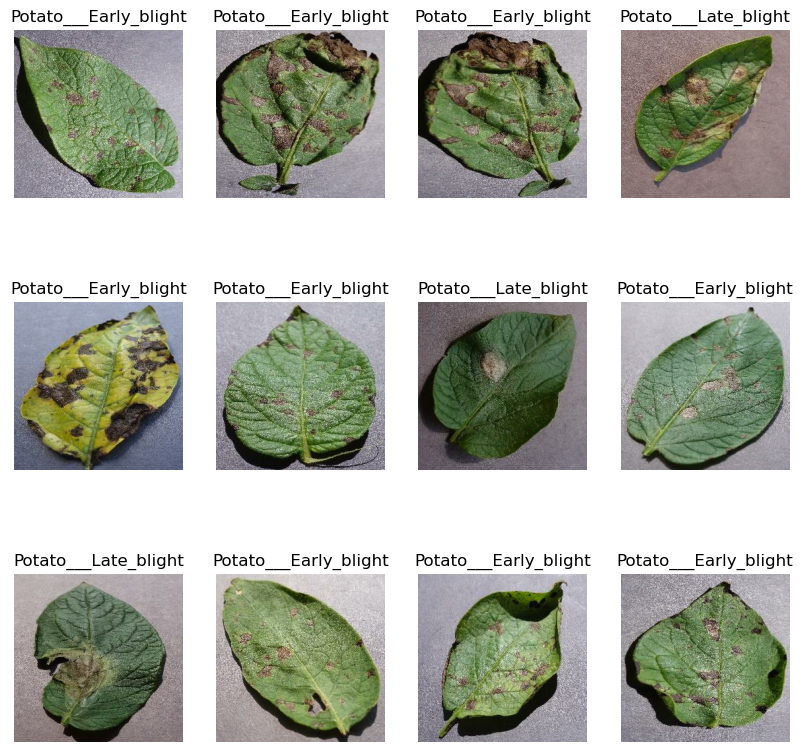

In [117]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [118]:
len(dataset)

68

In [119]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [120]:
train_ds = dataset.take(54)
len(train_ds)

54

In [121]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [122]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [123]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [124]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [125]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [126]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [127]:
len(train_ds)

54

In [128]:
len(val_ds)

6

In [129]:
len(test_ds)

8

In [130]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [131]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [132]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [133]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [134]:
# Function to create and compile model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [135]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_72 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_72 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_73 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_74 (Conv2D)          (32, 60, 60, 64)        

In [136]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [137]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 32s 546ms/step - loss: 0.8672 - accuracy: 0.5700 - val_loss: 0.8112 - val_accuracy: 0.5833
Epoch 2/50
54/54 [==============================] - 29s 527ms/step - loss: 0.5680 - accuracy: 0.7500 - val_loss: 0.4798 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 29s 530ms/step - loss: 0.3196 - accuracy: 0.8756 - val_loss: 0.4282 - val_accuracy: 0.7865
Epoch 4/50
54/54 [==============================] - 29s 527ms/step - loss: 0.3092 - accuracy: 0.8698 - val_loss: 0.2953 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 29s 529ms/step - loss: 0.2159 - accuracy: 0.9138 - val_loss: 0.2222 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 29s 531ms/step - loss: 0.2304 - accuracy: 0.9103 - val_loss: 0.2779 - val_accuracy: 0.8646
Epoch 7/50
54/54 [==============================] - 29s 530ms/step - loss: 0.1979 - accuracy: 0.9259 - val_loss: 0.2007 - val_accuracy: 0.9062

In [138]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 104ms/step - loss: 0.0735 - accuracy: 0.9922


In [139]:
scores

[0.07346086949110031, 0.9921875]

In [140]:
history

In [141]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [142]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [143]:
type(history.history['loss'])

list

In [144]:
len(history.history['loss'])

50

In [145]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8672412633895874,
 0.5679818987846375,
 0.3195725679397583,
 0.3092309236526489,
 0.2158893495798111]

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

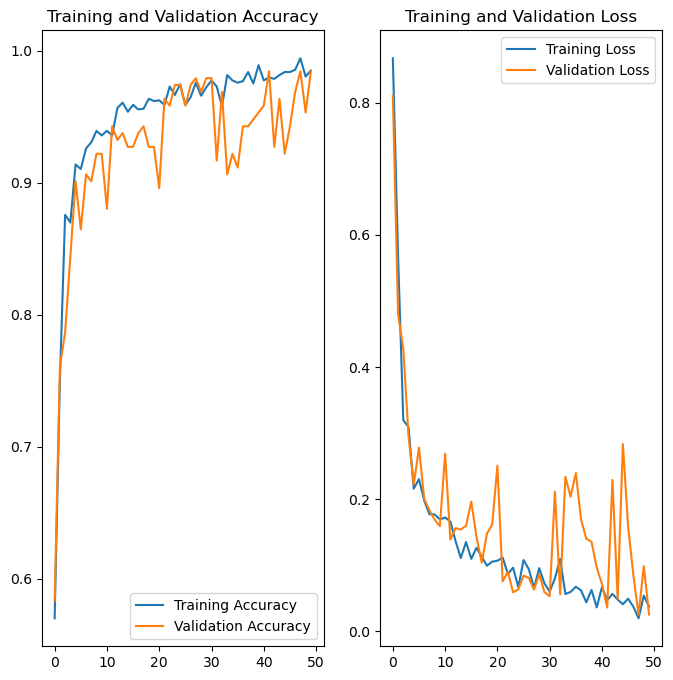

In [147]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 186ms/step
predicted label: Potato___Late_blight


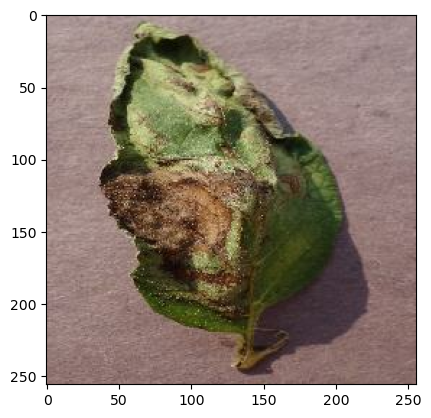

In [148]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [149]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


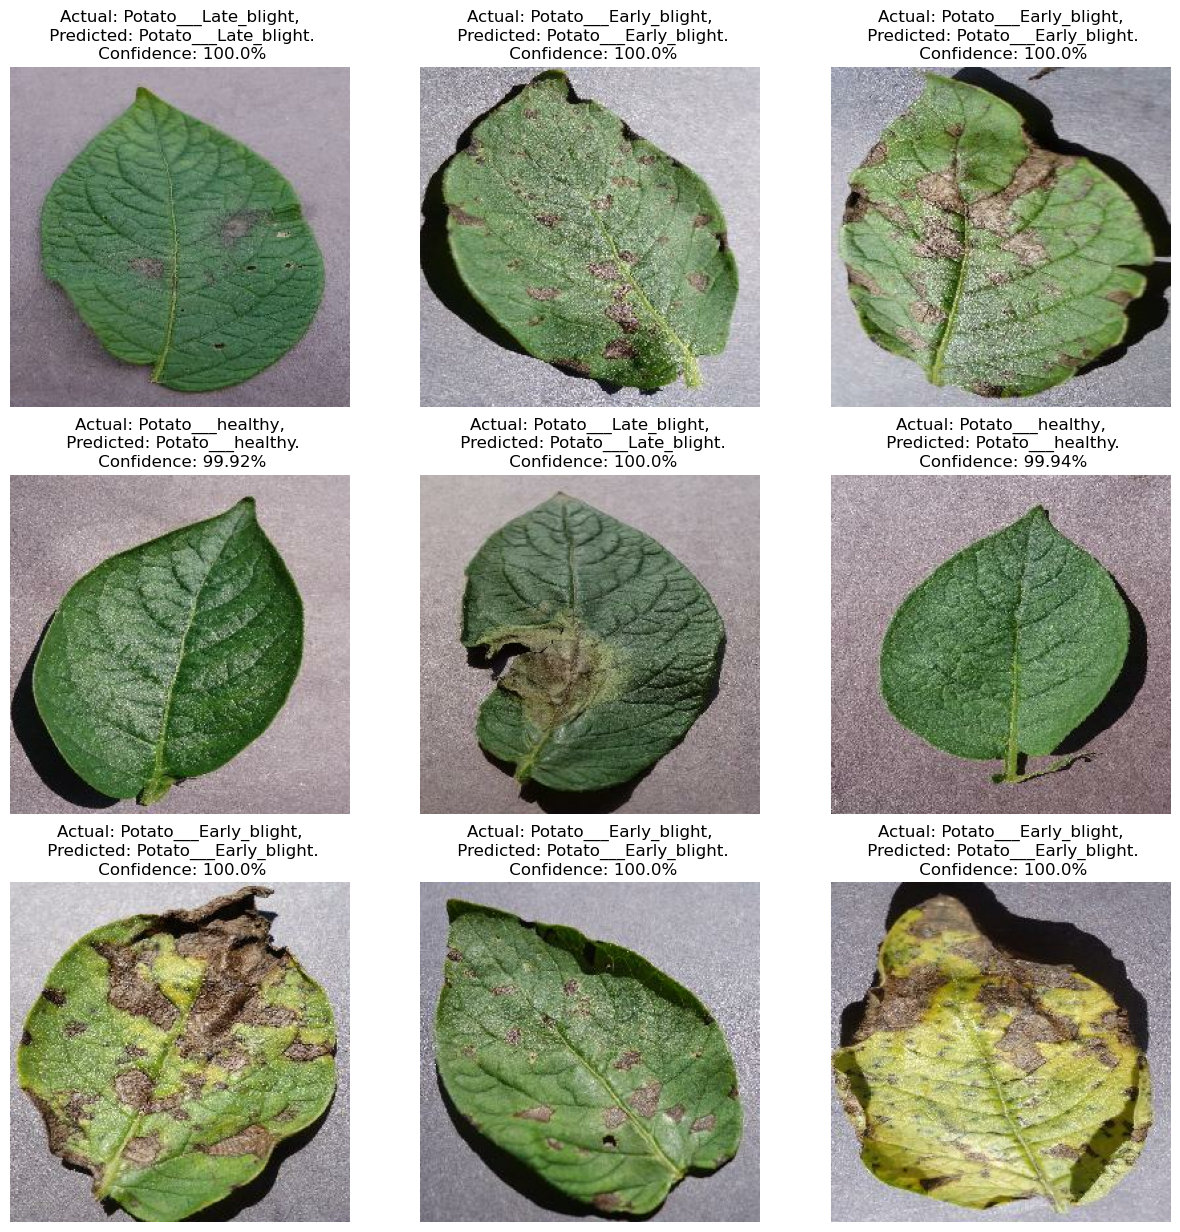

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [150]:
# Extracting images and labels from the dataset
images = []
labels = []
for image_batch, labels_batch in dataset:
    images.extend(image_batch.numpy())
    labels.extend(labels_batch.numpy())

In [151]:
# Converting to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [152]:
# Calculate number of classes
n_classes = 3

In [153]:
# K-fold cross-validation
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=123)
fold_accuracy = []
fold_confusion_matrices = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(images, labels)):
    print(f'Fold {fold + 1}/{N_FOLDS}')
    
    train_images, val_images = images[train_idx], images[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(train_images)).batch(BATCH_SIZE)
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)
    
    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    model.build(input_shape=input_shape)
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        verbose=1,
        epochs=EPOCHS
    )

Fold 1/5
Epoch 1/50
54/54 [==============================] - 29s 526ms/step - loss: 0.8655 - accuracy: 0.5032 - val_loss: 0.7199 - val_accuracy: 0.6752
Epoch 2/50
54/54 [==============================] - 28s 511ms/step - loss: 0.6614 - accuracy: 0.6915 - val_loss: 0.5193 - val_accuracy: 0.7633
Epoch 3/50
54/54 [==============================] - 28s 514ms/step - loss: 0.4703 - accuracy: 0.7926 - val_loss: 0.4334 - val_accuracy: 0.7889
Epoch 4/50
54/54 [==============================] - 28s 511ms/step - loss: 0.3885 - accuracy: 0.8373 - val_loss: 0.3017 - val_accuracy: 0.8515
Epoch 5/50
54/54 [==============================] - 27s 508ms/step - loss: 0.2692 - accuracy: 0.9030 - val_loss: 0.1945 - val_accuracy: 0.9258
Epoch 6/50
54/54 [==============================] - 28s 514ms/step - loss: 0.1812 - accuracy: 0.9338 - val_loss: 0.1403 - val_accuracy: 0.9490
Epoch 7/50
54/54 [==============================] - 27s 506ms/step - loss: 0.1538 - accuracy: 0.9442 - val_loss: 0.2521 - val_accurac

54/54 [==============================] - 28s 511ms/step - loss: 0.1941 - accuracy: 0.9279 - val_loss: 0.3015 - val_accuracy: 0.9002
Epoch 8/50
54/54 [==============================] - 27s 504ms/step - loss: 0.1423 - accuracy: 0.9483 - val_loss: 0.1754 - val_accuracy: 0.9397
Epoch 9/50
54/54 [==============================] - 27s 506ms/step - loss: 0.0955 - accuracy: 0.9675 - val_loss: 0.1766 - val_accuracy: 0.9281
Epoch 10/50
54/54 [==============================] - 27s 507ms/step - loss: 0.1167 - accuracy: 0.9506 - val_loss: 0.1443 - val_accuracy: 0.9397
Epoch 11/50
54/54 [==============================] - 27s 506ms/step - loss: 0.1062 - accuracy: 0.9628 - val_loss: 0.2037 - val_accuracy: 0.9072
Epoch 12/50
54/54 [==============================] - 27s 507ms/step - loss: 0.0724 - accuracy: 0.9709 - val_loss: 0.2023 - val_accuracy: 0.9350
Epoch 13/50
54/54 [==============================] - 27s 508ms/step - loss: 0.0595 - accuracy: 0.9756 - val_loss: 0.1989 - val_accuracy: 0.9327
Epoch 

54/54 [==============================] - 27s 506ms/step - loss: 0.0529 - accuracy: 0.9797 - val_loss: 0.1179 - val_accuracy: 0.9512
Epoch 14/50
54/54 [==============================] - 28s 513ms/step - loss: 0.0460 - accuracy: 0.9820 - val_loss: 0.2280 - val_accuracy: 0.9326
Epoch 15/50
54/54 [==============================] - 28s 511ms/step - loss: 0.0453 - accuracy: 0.9837 - val_loss: 0.1175 - val_accuracy: 0.9558
Epoch 16/50
54/54 [==============================] - 27s 508ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.1093 - val_accuracy: 0.9651
Epoch 17/50
54/54 [==============================] - 28s 513ms/step - loss: 0.0299 - accuracy: 0.9925 - val_loss: 0.2685 - val_accuracy: 0.9256
Epoch 18/50
54/54 [==============================] - 28s 513ms/step - loss: 0.0321 - accuracy: 0.9895 - val_loss: 0.1858 - val_accuracy: 0.9512
Epoch 19/50
54/54 [==============================] - 29s 530ms/step - loss: 0.0109 - accuracy: 0.9965 - val_loss: 0.1650 - val_accuracy: 0.9535
Epoc

54/54 [==============================] - 34s 629ms/step - loss: 0.0326 - accuracy: 0.9878 - val_loss: 0.0464 - val_accuracy: 0.9884
Epoch 20/50
54/54 [==============================] - 34s 637ms/step - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.0464 - val_accuracy: 0.9791
Epoch 21/50
54/54 [==============================] - 34s 635ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0416 - val_accuracy: 0.9860
Epoch 22/50
54/54 [==============================] - 33s 608ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9860
Epoch 23/50
54/54 [==============================] - 36s 675ms/step - loss: 6.9568e-04 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 0.9884
Epoch 24/50
54/54 [==============================] - 37s 688ms/step - loss: 3.3763e-04 - accuracy: 1.0000 - val_loss: 0.0482 - val_accuracy: 0.9860
Epoch 25/50
54/54 [==============================] - 37s 676ms/step - loss: 2.1614e-04 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy:

54/54 [==============================] - 27s 506ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9814
Epoch 26/50
54/54 [==============================] - 28s 512ms/step - loss: 5.5283e-04 - accuracy: 1.0000 - val_loss: 0.0433 - val_accuracy: 0.9930
Epoch 27/50
54/54 [==============================] - 27s 507ms/step - loss: 2.4742e-04 - accuracy: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9907
Epoch 28/50
54/54 [==============================] - 27s 509ms/step - loss: 1.7774e-04 - accuracy: 1.0000 - val_loss: 0.0484 - val_accuracy: 0.9930
Epoch 29/50
54/54 [==============================] - 27s 503ms/step - loss: 1.4485e-04 - accuracy: 1.0000 - val_loss: 0.0509 - val_accuracy: 0.9907
Epoch 30/50
54/54 [==============================] - 27s 503ms/step - loss: 1.1848e-04 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9930
Epoch 31/50
54/54 [==============================] - 27s 509ms/step - loss: 1.0307e-04 - accuracy: 1.0000 - val_loss: 0.0516 - v

In [155]:
# Evaluate on validation set
_, accuracy = model.evaluate(val_ds)
fold_accuracy.append(accuracy)

14/14 [==============================] - 1s 103ms/step - loss: 0.0613 - accuracy: 0.9930


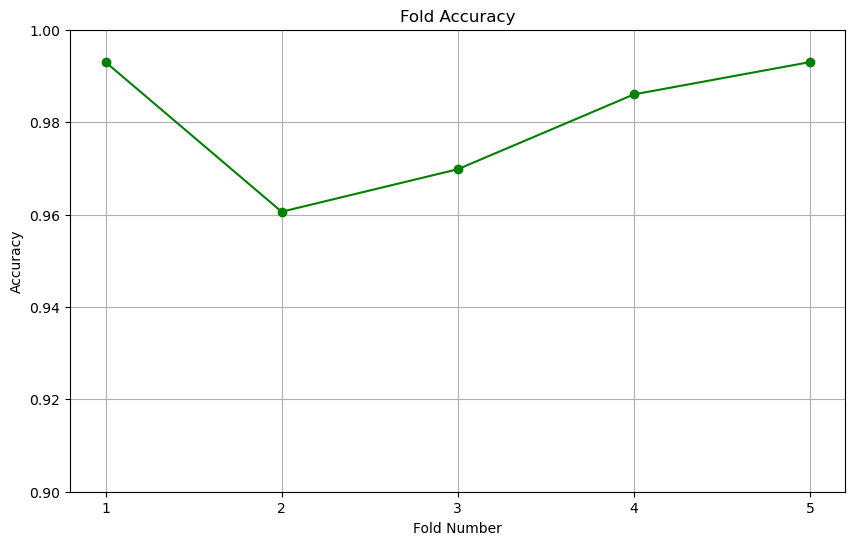

In [175]:
# List of accuracies for each fold
fold_accuracies = [0.9930, 0.9606, 0.9698, 0.9860, 0.9930]  

# Plotting the accuracy for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', linestyle='-', color='g')
plt.title('Fold Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.xticks(range(1, len(fold_accuracies) + 1))
plt.grid(True)
plt.show()

In [156]:
# Predictions and confusion matrix
y_true = []
y_pred = []
for images_batch, labels_batch in val_ds:
        y_true.extend(labels_batch.numpy())
        batch_prediction = model.predict(images_batch)
        y_pred.extend(np.argmax(batch_prediction, axis=1))

1/1 [==============================] - 0s 136ms/step


In [157]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
fold_confusion_matrices.append(cm)

In [158]:
# Print model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_102 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_102 (MaxPool  (None, 127, 127, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_103 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_103 (MaxPool  (None, 62, 62, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_104 (Conv2D)         (None, 60, 60, 64)      

In [159]:
# Print mean accuracy
print(f'Mean Accuracy: {np.mean(fold_accuracy)}')

Mean Accuracy: 0.9930232763290405


In [160]:
# Print mean confusion matrix
mean_cm = np.mean(fold_confusion_matrices, axis=0)
print('Mean Confusion Matrix:')
print(mean_cm)

Mean Confusion Matrix:
[[198.   2.   0.]
 [  0. 200.   0.]
 [  0.   1.  29.]]


In [162]:
class_names = dataset.class_names

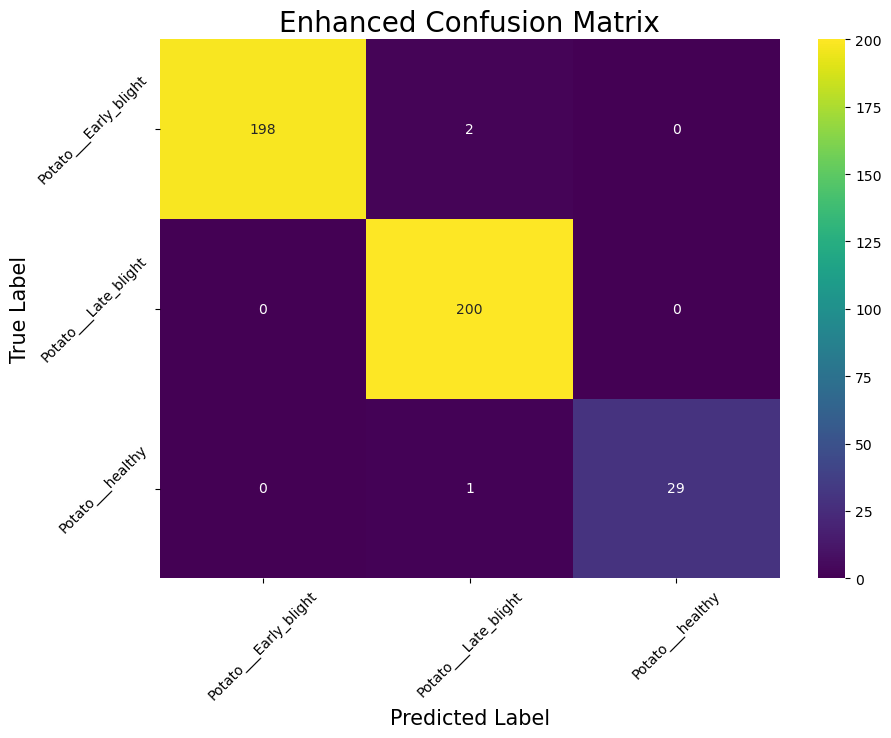

In [164]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Enhanced Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [189]:
# Extract values from confusion matrix
true_positive = 198
false_negative = 2
false_positive = 1
true_negative = 200

# Compute Precision, Recall, and F1-Score
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.9949748743718593
Recall: 0.99
F1-Score: 0.9924812030075189


In [168]:
model.save("../potato2024.h5")

C:\Users\sohel\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
